# Mean Reversion (Bollinger Bands) Backtester

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
from oandapyV20.exceptions import V20Error
from itertools import product
from dateutil import relativedelta
from datetime import datetime

class MeanRevBacktester():
    ''' Class for the backtesting of Bollinger Bands-based trading strategies. '''

    def __init__(self, instrument, SMA, dev, start, end, tc, granularity, access_token, price):
        self.instrument = instrument
        self.SMA = SMA
        self.dev = dev
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.granularity = granularity
        self.price = price
        self.access_token = access_token
        self.client = API(access_token=self.access_token)
        self.tp_year = None  # For annualized calculations

        self.params = {
            "granularity": self.granularity,
            "from": self.start,
            "to": self.end
        }

        # Divide the date range into monthly intervals
        start_date = datetime.strptime(self.start, '%Y-%m-%d')
        end_date = datetime.strptime(self.end, '%Y-%m-%d')
        date_ranges = []
        while start_date < end_date:
            next_month = start_date + relativedelta.relativedelta(months=1)
            if next_month > end_date:
                next_month = end_date
            date_ranges.append((start_date.strftime('%Y-%m-%d'), next_month.strftime('%Y-%m-%d')))
            start_date = next_month
        
        # Initialize an empty dataframe
        data = pd.DataFrame()

        # Loop over the monthly intervals and append the data to the dataframe
        for date_range in date_ranges:
            self.params["from"] = date_range[0]
            self.params["to"] = date_range[1]
            df = self.get_data()
            data = pd.concat([data, df])

        self.data = data
        self.prepare_data()
        self.tp_year = (self.data.price.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))  # For annualized calculations

    def __repr__(self):
        return "MeanRevBacktester(symbol = {}, SMA = {}, dev = {}, start = {}, end = {})".format(self.instrument, self.SMA, self.dev, self.start, self.end)

    def get_data(self):
        try:
            r = instruments.InstrumentsCandles(instrument=self.instrument, params=self.params)
            response = self.client.request(r)

            # Parse the response into a Pandas DataFrame
            data = pd.DataFrame(response['candles'])
            data['time'] = pd.to_datetime(data['time'], format="%Y-%m-%dT%H:%M:%S.%f000Z")
            data.set_index('time', inplace=True)
            data.sort_index(inplace=True)
            data['c'] = data['mid'].apply(lambda x: x['c'])
            data.rename(columns={'c': 'price'}, inplace=True)
            data['price'] = pd.to_numeric(data['price'], errors='coerce')
            data.drop(columns=['complete', 'mid', 'volume'], inplace=True)
            data["returns"] = np.log(data['price'] / data['price'].shift(1))
            return data
        except V20Error as e:
            print(f"Error: {e}")
            return pd.DataFrame()

    def prepare_data(self):
        '''Prepares the data for strategy backtesting (strategy-specific).'''
        data = self.data.copy()
        data["SMA"] = data["price"].rolling(self.SMA).mean()
        data["Lower"] = data["SMA"] - data["price"].rolling(self.SMA).std() * self.dev
        data["Upper"] = data["SMA"] + data["price"].rolling(self.SMA).std() * self.dev
        self.data = data

    def set_parameters(self, SMA=None, dev=None):
        ''' Updates parameters (SMA, dev) and the prepared dataset. '''
        if SMA is not None:
            self.SMA = SMA
            self.data["SMA"] = self.data["price"].rolling(self.SMA).mean()
            self.data["Lower"] = self.data["SMA"] - self.data["price"].rolling(self.SMA).std() * self.dev
            self.data["Upper"] = self.data["SMA"] + self.data["price"].rolling(self.SMA).std() * self.dev
        if dev is not None:
            self.dev = dev
            self.data["Lower"] = self.data["SMA"] - self.data["price"].rolling(self.SMA).std() * self.dev
            self.data["Upper"] = self.data["SMA"] + self.data["price"].rolling(self.SMA).std() * self.dev

    def test_strategy(self):
        ''' Backtests the Bollinger Bands-based trading strategy. '''
        data = self.data.copy().dropna()
        data["distance"] = data.price - data.SMA
        data["position"] = np.where(data.price < data.Lower, 1, np.nan)
        data["position"] = np.where(data.price > data.Upper, -1, data["position"])
        data["position"] = np.where(data.distance * data.distance.shift(1) < 0, 0, data["position"])
        data["position"] = data.position.ffill().fillna(0)
        data["strategy"] = data.position.shift(1) * data["returns"]
        data.dropna(inplace=True)

        # determine the number of trades in each bar
        data["trades"] = data.position.diff().fillna(0).abs()

        # subtract transaction/trading costs from pre-cost return
        data.strategy = data.strategy - data.trades * self.tc

        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data

        perf = data["cstrategy"].iloc[-1]  # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1]  # out-/underperformance of strategy

        return perf, outperf

    def plot_results(self):
        ''' Plots the performance of the trading strategy and compares to "buy and hold". '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | SMA = {} | dev = {}".format(self.instrument, self.SMA, self.dev)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))


    def optimize_parameters(self, SMA_range, dev_range):
        ''' Finds the optimal strategy given the Bollinger Bands parameter ranges. '''
        combinations = list(product(range(*SMA_range), range(*dev_range)))
        results = []
        for comb in combinations:
            self.set_parameters(comb[0], comb[1])
            results.append(self.test_strategy()[0])
        
        best_perf = np.max(results)  # best performance
        opt = combinations[np.argmax(results)]  # optimal parameters

        # run/set the optimal strategy
        self.set_parameters(opt[0], opt[1])
        self.test_strategy()

        # create a df with many results
        many_results = pd.DataFrame(data=combinations, columns=["SMA", "dev"])
        many_results["performance"] = results
        self.results_overview = many_results
        return opt, best_perf
    
    def optimize_strategy(self, param_range, param_type="SMA", metric="Multiple"):
        '''
        Backtests strategy for different parameter values. It independently tests each parameter's optimal value based on the performance metric.
        
        Parameters
        ===========
        param_range: tuple
            tuples of the form (start, end, step size).
        param_type: str
            which parameter to optimize (either "SMA" or "dev").
        metric: str
            performance metric to be optimized (can be: "Multiple", "Sharpe", "Sortino", "Calmar", "Kelly").
        '''
        
        # Choose the performance metric function
        self.metric = metric
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        elif metric == "Sortino":
            performance_function = self.calculate_sortino
        elif metric == "Calmar": 
            performance_function = self.calculate_calmar
        elif metric == "Kelly": 
            performance_function = self.calculate_kelly_criterion
        else:
            raise ValueError("Unknown metric!")

        # Set up parameter ranges
        params = range(*param_range)
        
        # Store performance for each parameter combination
        performance = []
        
        for param in params:
            # Set the parameter based on the param_type (either "SMA" or "dev")
            if param_type == "SMA":
                self.set_parameters(SMA=param)
            elif param_type == "dev":
                self.set_parameters(dev=param)
            else:
                raise ValueError("Invalid param_type. Choose 'SMA' or 'dev'.")
            
            # Run the backtest and compute the performance based on the chosen metric
            
            performance.append(performance_function(self.results.strategy))
        
        # Store the results in a dataframe
        self.results_overview = pd.DataFrame(data=params, columns=[param_type])
        self.results_overview["Performance"] = performance
        
        # Find the best strategy
        self.find_best_strategy(param_type)

    def find_best_strategy(self, param_type):
        ''' Finds the optimal strategy given the parameter range. It can test for the SMA values or dev values'''
        best = self.results_overview.nlargest(1, "Performance")
        optimal_param = best[param_type].iloc[0]
        optimal_perf = best.Performance.iloc[0]
        
        print(f"Optimal {param_type}: {optimal_param} | {self.metric}: {round(optimal_perf, 6)}")
        
        # Set the optimal parameter and print the final strategy performance
        if param_type == "SMA":
            self.set_parameters(SMA=optimal_param)
        elif param_type == "dev":
            self.set_parameters(dev=optimal_param)
        
        self.test_strategy()  # Print the performance for the optimal parameter



    def print_performance(self):
        ''' Calculates and prints various Performance Metrics. '''
        
        data = self.results.copy()
        strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
        bh_multiple = round(self.calculate_multiple(data.returns), 6)
        outperf = round(strategy_multiple - bh_multiple, 6)
        cagr = round(self.calculate_cagr(data.strategy), 6)
        ann_mean = round(self.calculate_annualized_mean(data.strategy), 6)
        ann_std = round(self.calculate_annualized_std(data.strategy), 6)
        sharpe = round(self.calculate_sharpe(data.strategy), 6)
        sortino = round(self.calculate_sortino(data.strategy), 6)
        max_drawdown = round(self.calculate_max_drawdown(data.strategy), 6)
        calmar = round(self.calculate_calmar(data.strategy), 6)
        max_dd_duration = round(self.calculate_max_dd_duration(data.strategy), 6)
        kelly_criterion = round(self.calculate_kelly_criterion(data.strategy), 6)
        
        print(100 * "=")
        print("BOLLINGER BANDS STRATEGY | INSTRUMENT = {} | SMA = {} | DEV = {}".format(self.instrument, self.SMA, self.dev))
        print(100 * "-")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        print("Sortino Ratio:               {}".format(sortino))
        print("Maximum Drawdown:            {}".format(max_drawdown))
        print("Calmar Ratio:                {}".format(calmar))
        print("Max Drawdown Duration:       {} Days".format(max_dd_duration))
        print("Kelly Criterion:             {}".format(kelly_criterion))
        print(100 * "=")

    def calculate_multiple(self, series):
        return np.exp(series.sum())

    def calculate_cagr(self, series):
        return np.exp(series.sum()) ** (1 / ((series.index[-1] - series.index[0]).days / 365.25)) - 1

    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year

    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)

    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return series.mean() / series.std() * np.sqrt(self.tp_year)

    def calculate_sortino(self, series):
        excess_returns = series - 0
        downside_deviation = np.sqrt(np.mean(np.where(excess_returns < 0, excess_returns, 0) ** 2))
        if downside_deviation == 0:
            return np.nan
        else:
            return series.mean() / downside_deviation * np.sqrt(self.tp_year)

    def calculate_max_drawdown(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns) / cummax
        return drawdown.max()

    def calculate_calmar(self, series):
        max_dd = self.calculate_max_drawdown(series)
        if max_dd == 0:
            return np.nan
        else:
            cagr = self.calculate_cagr(series)
            return cagr / max_dd

    def calculate_max_dd_duration(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns) / cummax
        begin = drawdown[drawdown == 0].index
        end = begin[1:]
        end = end.append(pd.DatetimeIndex([drawdown.index[-1]]))
        periods = end - begin
        return periods.max().days

    def calculate_kelly_criterion(self, series):
        series = np.exp(series) - 1
        if series.var() == 0:
            return np.nan
        else:
            return series.mean() / series.var()

### Creating an instance of the class

In [111]:
trader = MeanRevBacktester('EUR_USD', 30, 2, '2010-01-01', '2011-01-01', .00007, 'H1', '65ea0aa854d23214e7ecab3851b38115-003a1258c7194456707c1e4d45bc6d33', 'A')


### Getting the data

In [112]:
trader.get_data()

,price,returns
time,,
2010-12-01 05:00:00,1.30228,NaN
2010-12-01 06:00:00,1.30320,0.000706
2010-12-01 07:00:00,1.30463,0.001097
2010-12-01 08:00:00,1.30757,0.002251
2010-12-01 09:00:00,1.30708,-0.000375
...,...,...
2010-12-31 18:00:00,1.33487,-0.000988
2010-12-31 19:00:00,1.33713,0.001692
2010-12-31 20:00:00,1.33698,-0.000112


### Testing the strategy

In [113]:
trader.test_strategy()

(0.8330397691167718, -0.09275176405435903)

### Printing out performace metrics

In [114]:
trader.print_performance()

BOLLINGER BANDS STRATEGY | INSTRUMENT = EUR_USD | SMA = 30 | DEV = 2
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         0.83304
Multiple (Buy-and-Hold):     0.925792
--------------------------------------
Out-/Underperformance:       -0.092752


CAGR:                        -0.169176
Annualized Mean:             -0.185482
Annualized Std:              0.091119
Sharpe Ratio:                -2.035606
Sortino Ratio:               -2.719169
Maximum Drawdown:            0.188075
Calmar Ratio:                -0.899518
Max Drawdown Duration:       357 Days
Kelly Criterion:             -21.852558


### Plotting the results compared to buy and hold

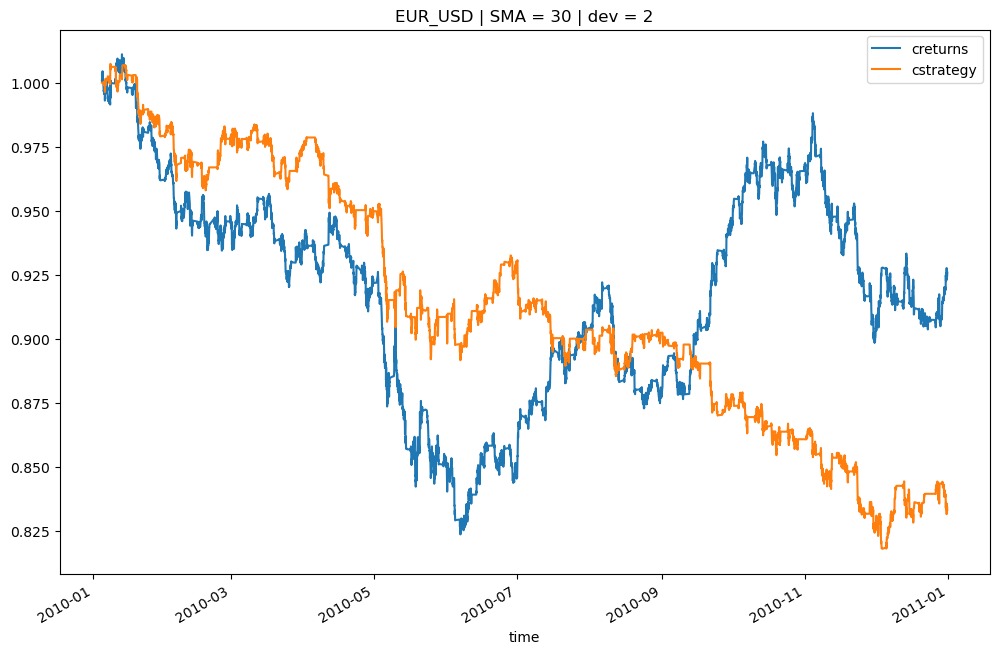

In [115]:
trader.plot_results()

### Calculating the optimal parameters to maximize the multiple

In [116]:
trader.optimize_parameters((10,250), (1,20))

((10, 2), 1.0795639158036758)

### Printing out the performance metrics

In [117]:
trader.print_performance()

BOLLINGER BANDS STRATEGY | INSTRUMENT = EUR_USD | SMA = 10 | DEV = 2
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.079564
Multiple (Buy-and-Hold):     0.933401
--------------------------------------
Out-/Underperformance:       0.146163


CAGR:                        0.080537
Annualized Mean:             0.077495
Annualized Std:              0.072633
Sharpe Ratio:                1.06693
Sortino Ratio:               1.527099
Maximum Drawdown:            0.055894
Calmar Ratio:                1.440907
Max Drawdown Duration:       126 Days
Kelly Criterion:             15.187901


### Plotting the results

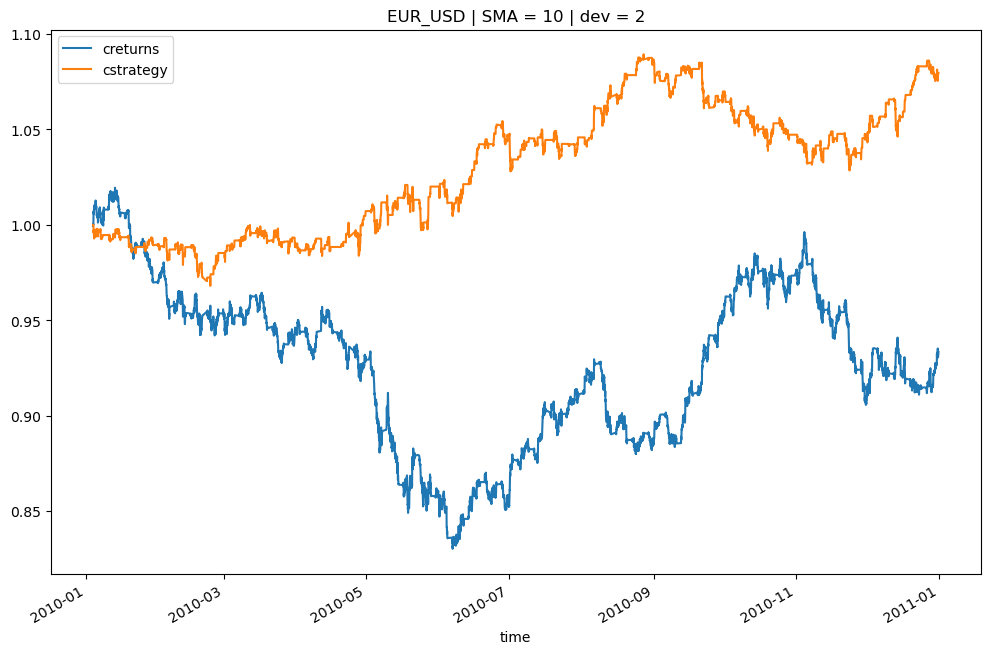

In [118]:
trader.plot_results()

### Optimizing the SMA based on the Sharpe Ratio

In [131]:
trader.optimize_strategy((10,200), "SMA", "Sharpe")

Optimal SMA: 10 | Sharpe: -0.901135


### Optimizing the Sharpe Ratio based on the dev values

In [132]:
trader.optimize_strategy((1,10), "dev", "Sharpe")

Optimal dev: 1 | Sharpe: -0.901135


### Printing out the rest of the metrics based on the strategy

In [129]:
trader.print_performance()

BOLLINGER BANDS STRATEGY | INSTRUMENT = EUR_USD | SMA = 10 | DEV = 1
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         0.917415
Multiple (Buy-and-Hold):     0.933401
--------------------------------------
Out-/Underperformance:       -0.015986


CAGR:                        -0.083516
Annualized Mean:             -0.087251
Annualized Std:              0.096824
Sharpe Ratio:                -0.901135
Sortino Ratio:               -1.232286
Maximum Drawdown:            0.101142
Calmar Ratio:                -0.825731
Max Drawdown Duration:       337 Days
Kelly Criterion:             -8.809711


### Plotting the results

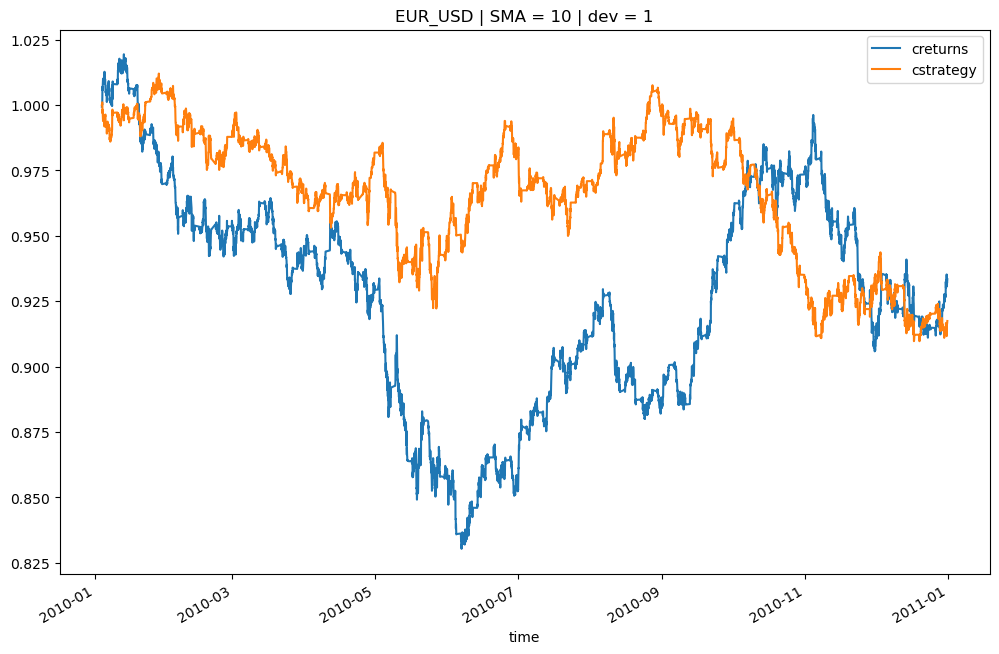

In [130]:
trader.plot_results()